In [8]:
import pandas as pd
import networkx as nx

# Hardcoded path to price matrix
price_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\only_original_data\price_matrix.parquet"
price_df = pd.read_parquet(price_file)

# Threshold for significant correlation
threshold = 0.3

# Compute Pearson correlation for prices
price_corr_pearson = price_df.corr(method='pearson').copy()

# Create network graph
G_price = nx.Graph()

# Add nodes (mandis)
for mandi in price_df.columns:
    G_price.add_node(mandi)

# Add edges for correlations above threshold
for i in price_df.columns:
    for j in price_df.columns:
        if i != j:
            corr_value = price_corr_pearson.loc[i, j]
            if abs(corr_value) >= threshold:
                G_price.add_edge(i, j, weight=corr_value)

print("✅ Weighted mandi network created (G_price).")
print("Nodes:", G_price.number_of_nodes())
print("Edges:", G_price.number_of_edges())


✅ Weighted mandi network created (G_price).
Nodes: 1600
Edges: 837010


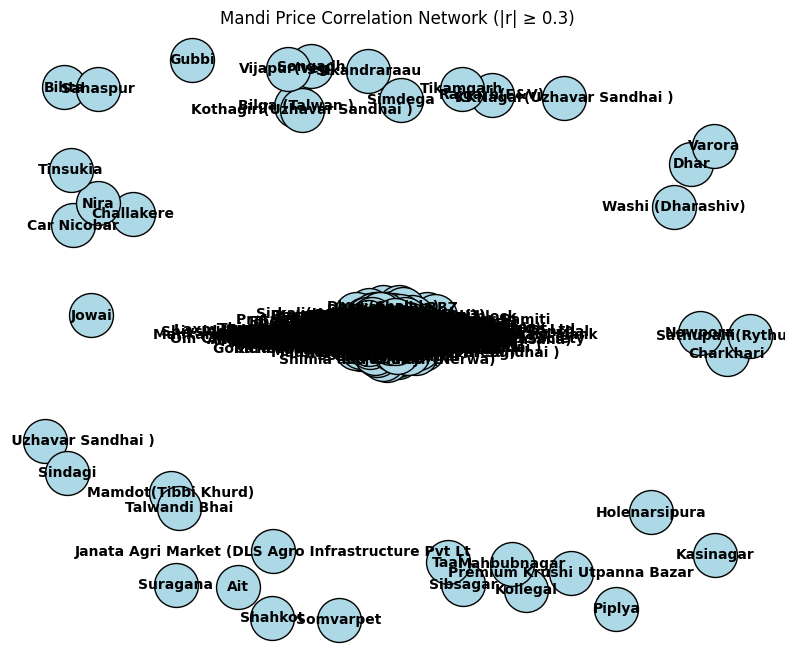

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Draw positions for nodes (you can experiment with different layouts)
pos = nx.spring_layout(G_price, seed=42)  # Force-directed layout

# Extract edge weights (correlation values)
weights = [G_price[u][v]['weight'] for u, v in G_price.edges()]

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G_price, pos, node_color='lightblue', node_size=1000, edgecolors='black')
nx.draw_networkx_labels(G_price, pos, font_size=10, font_weight='bold')

# Draw edges with thickness proportional to |correlation|
nx.draw_networkx_edges(G_price, pos, width=[abs(w) * 5 for w in weights], alpha=0.6)

# Add a title and display
plt.title("Mandi Price Correlation Network (|r| ≥ 0.3)")
plt.axis('off')
plt.show()


✅ Loaded price matrix: (2497, 1600)
✅ Correlation matrix computed.
✅ Graph created with 1600 nodes and 837010 edges.
✅ Network metrics computed.

🔝 Top 10 Mandis by Weighted Degree:

               Weighted Degree  Betweenness Centrality  Clustering Coefficient
Raibareilly          1188.6948                  0.0000                  0.5416
Unnao                1187.4911                  0.0000                  0.5427
Muzzafarnagar        1183.9489                  0.0000                  0.5478
Saharanpur           1182.4690                  0.0000                  0.5515
Azamgarh             1180.9795                  0.0000                  0.5459
Shamli               1180.8007                  0.0000                  0.5490
Akbarpur             1178.8332                  0.8232                  0.5469
Ajuha                1177.8732                  0.9305                  0.5458
Sultanpur            1177.6965                  0.0000                  0.5425
Basti                1177.1

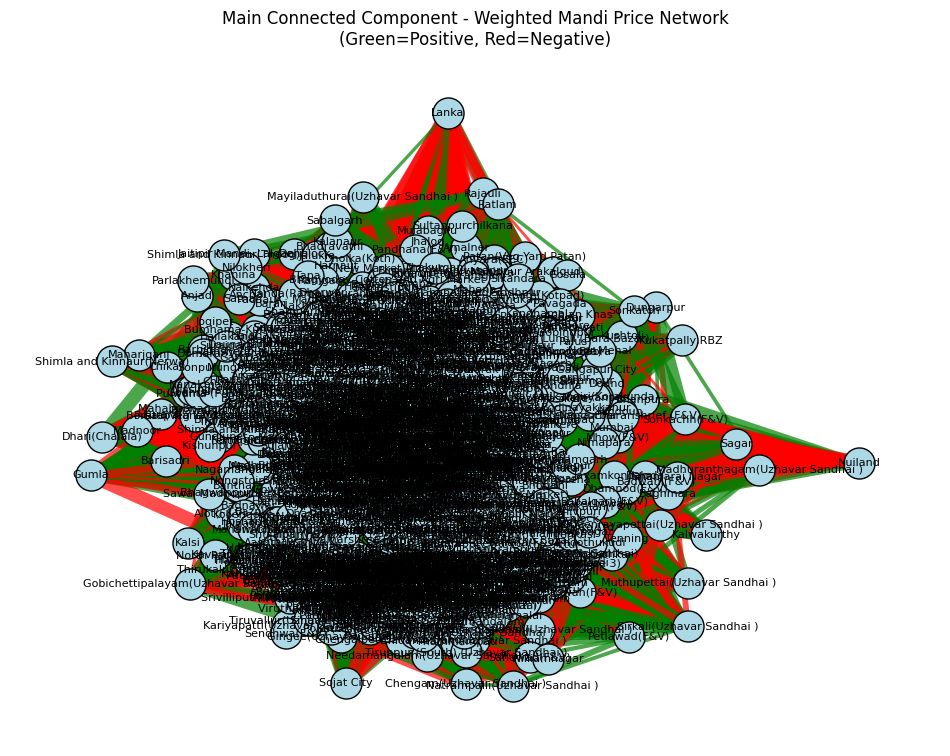

✅ Dataset saved: edges + network metrics.


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# STEP 1: Load price matrix
# ============================================================
price_file = r"C:\Users\PESU-RF\Downloads\Onions\Onions\processed_data\only_original_data\price_matrix.parquet"
price_df = pd.read_parquet(price_file)
print(f"✅ Loaded price matrix: {price_df.shape}")

# ============================================================
# STEP 2: Compute correlation matrix
# ============================================================
threshold = 0.3  # minimum correlation for an edge
price_corr = price_df.corr(method='pearson')
print("✅ Correlation matrix computed.")

# ============================================================
# STEP 3: Vectorized edge creation
# ============================================================
corr_values = price_corr.values
nodes = price_df.columns

# Find pairs with |correlation| >= threshold (exclude self-correlation)
indices = np.where(np.abs(corr_values) >= threshold)
edges = [(nodes[i], nodes[j], corr_values[i,j]) 
         for i,j in zip(*indices) if i != j]

# Build graph
G_price = nx.Graph()
G_price.add_nodes_from(nodes)
G_price.add_weighted_edges_from(edges)
print(f"✅ Graph created with {G_price.number_of_nodes()} nodes and {G_price.number_of_edges()} edges.")

# ============================================================
# STEP 4: Weighted network metrics
# ============================================================
# Weighted degree
weighted_degree = dict(G_price.degree(weight='weight'))

# Clustering coefficient
clustering = nx.clustering(G_price, weight='weight')

# Betweenness centrality (approximate for speed)
# k=100 means sample 100 nodes for approximation
bet_centrality = nx.betweenness_centrality(G_price, k=100, weight='weight', seed=42)
print("✅ Network metrics computed.")

# Combine into DataFrame
stats_df = pd.DataFrame({
    'Weighted Degree': weighted_degree,
    'Betweenness Centrality': bet_centrality,
    'Clustering Coefficient': clustering
}).sort_values(by='Weighted Degree', ascending=False)

print("\n🔝 Top 10 Mandis by Weighted Degree:\n")
print(stats_df.head(10).round(4))

# ============================================================
# STEP 5: Focus on main connected component for visualization
# ============================================================
largest_cc = max(nx.connected_components(G_price), key=len)
G_main = G_price.subgraph(largest_cc).copy()
print(f"\nMain connected component has {len(G_main)} mandis.")

# Safe visualization: only main component
pos_main = nx.spring_layout(G_main, weight='weight', seed=42, iterations=50)  # faster with fewer iterations

# Extract weights and colors
weights = np.array([abs(G_main[u][v]['weight']) for u,v in G_main.edges()])
edge_colors = ['green' if G_main[u][v]['weight'] > 0 else 'red' for u,v in G_main.edges()]
# Scale edge widths
min_w, max_w = weights.min(), weights.max()
scaled_widths = 2 + 8 * (weights - min_w) / (max_w - min_w)

plt.figure(figsize=(12,9))
nx.draw_networkx_nodes(G_main, pos_main, node_color='lightblue', node_size=500, edgecolors='black')
nx.draw_networkx_labels(G_main, pos_main, font_size=8)
nx.draw_networkx_edges(G_main, pos_main, edge_color=edge_colors, width=scaled_widths, alpha=0.7)
plt.title("Main Connected Component - Weighted Mandi Price Network\n(Green=Positive, Red=Negative)")
plt.axis('off')
plt.show()

# ============================================================
# STEP 6: Save dataset for further use
# ============================================================
# Save edges with weights
edges_df = pd.DataFrame(edges, columns=['Mandi1', 'Mandi2', 'Weight'])
edges_df.to_csv("mandi_price_network_edges.csv", index=False)

# Save network stats
stats_df.to_csv("mandi_price_network_stats.csv")
print("✅ Dataset saved: edges + network metrics.")


In [8]:
import geojson

# Hardcoded mandi coordinates dictionary
mandi_coords = {
    'Lasalgaon': (20.1, 75.9),
    'Delhi': (28.6, 77.2),
    'Kolkata': (22.6, 88.4),
    'Chitradurga': (14.2, 76.4)
    # add other mandis as needed
}

nodes_geojson = []
for node in G_price.nodes:
    lat, lon = mandi_coords[node]
    nodes_geojson.append(
        geojson.Feature(geometry=geojson.Point((lon, lat)), properties={"mandi": node})
    )

features = geojson.FeatureCollection(nodes_geojson)

# Hardcoded output file
geojson_file = r"C:\Users\PESU-RF\Downloads\Onions\mandi_network_nodes.geojson"
with open(geojson_file, "w") as f:
    geojson.dump(features, f)

print(f"✅ GeoJSON saved to {geojson_file}")


KeyError: 'A lot'

In [7]:
%pip install scipy

   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   -- ------------------------------------- 2.1/38.5 MB 10.8 MB/s eta 0:00:04
   ---- ----------------------------------- 4.5/38.5 MB 10.9 MB/s eta 0:00:04
   ------ --------------------------------- 6.6/38.5 MB 10.8 MB/s eta 0:00:03
   -------- ------------------------------- 8.4/38.5 MB 10.6 MB/s eta 0:00:03
   ----------- ---------------------------- 11.0/38.5 MB 10.7 MB/s eta 0:00:03
   -------------- ------------------------- 13.6/38.5 MB 11.1 MB/s eta 0:00:03
   ----------------- ---------------------- 16.5/38.5 MB 11.6 MB/s eta 0:00:02
   ------------------- -------------------- 18.9/38.5 MB 11.6 MB/s eta 0:00:02
   ---------------------- ----------------- 21.5/38.5 MB 11.7 MB/s eta 0:00:02
   ------------------------- -------------- 24.1/38.5 MB 11.9 MB/s eta 0:00:02
   ---------------------------- ----------- 27.5/38.5 MB 12.2 MB/s eta 0:00:01
   ------------------------------- -------- 29.9/38.5 MB 12.2 MB/


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
